`Julian Rippert - MIDS Spring 2023`

In [6]:
# standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

np.set_printoptions(suppress=True)
pd.options.display.float_format = "{:,.6f}".format

#import operator

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# pipelines
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline

# data preprocessing, cross-validation, accuracies
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix,RocCurveDisplay,  PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score,auc, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# individual classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 

# ensemble classifiers
##(not that we use a user defined class for MajorityVoting)
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Tree Visualisation
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# others
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

#need this as we have a lot of columns
pd.options.display.max_rows = 1000

#hide warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/var/folders/wf/2spndysd73n094ypc_bf19240000gn/T/ipykernel_30083/563490316.py:49: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


## Motivation

This data set stems from the __[American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/data)__ data set on kaggle.

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

 the following features being categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


**Why do we care?** - Default events are financially unfavorable for banks and card issuers since they will not be able to recoup the monies lent out to consumers through credit. Banks may use such default prediction models to monitor its current card-holder base and proactively work with consumers to avoid default actions. Banks may also use such default prediction models to help decide whether or not to issue credit to potential new customers.

___

## Miscellaneous

In [7]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

___

## Loading in the Data

read the data from @munumbutt's __[AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather)__ In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit

In [8]:
%%time 
df = pd.read_feather('train_data.ftr')

CPU times: user 3.49 s, sys: 8.05 s, total: 11.5 s
Wall time: 3.22 s


`Lets take a look at the data`

In [9]:
display(df.head(2))
#df.value_counts()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


Since it is a time series dataset, we have to sort it by the date or S_2 feature, then will seperate into the train and test split.

In [10]:
df = df.sort_values(by ='S_2')


___

## Exploratory Data Analysis

From the describe below we can confirm that the data is already normalized which was mentioned in the kaggle prompt. Mean data is mostly nan since many columns have nans, we will deal with these later one

For EDA purposes we will take a sample of the dataframe given its size

In [11]:
#since we want to maintain the integrity of our test data set we can look at the first 35% of rows 
n = 35
eda_df = df.head(int(len(df)*(n/100)))

In [14]:
#did head method from compacter printer to PDF purposes
eda_describ = eda_df.describe().transpose()

In [16]:
#since I know there are many NaN lets see its standardized properly by returning non Nan rows
eda_describ[~eda_describ.isnull().any(axis=1)].head()

,count,mean,std,min,25%,50%,75%,max
D_42,"283,952.000000",0.000000,0.000000,-0.000372,0.040314,0.123779,0.258057,4.187500
D_49,"171,995.000000",0.000000,0.000000,0.000007,0.062439,0.131104,0.245972,19.953125
D_53,"477,308.000000",0.000000,0.000000,0.000000,0.005875,0.011810,0.039185,7.902344
R_4,"1,936,007.000000",0.000000,0.000000,0.000000,0.002539,0.005081,0.007626,1.009766
R_5,"1,936,007.000000",0.000000,0.000000,0.000000,0.002550,0.005096,0.007645,17.515625


In [198]:
categoricals = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for i in categoricals:
    print(eda_df[i].value_counts())

0.0    1679272
1.0     238519
2.0      17264
Name: B_30, dtype: int64
2.0    726993
3.0    442452
1.0    390498
5.0    147417
4.0     94695
7.0     81702
6.0     51298
Name: B_38, dtype: int64
1.0    1151826
0.0     726763
Name: D_114, dtype: int64
0.0    1876702
1.0       1887
Name: D_116, dtype: int64
-1.0    504835
3.0     416188
4.0     396819
2.0     242197
5.0     156953
6.0     114790
1.0      46807
Name: D_117, dtype: int64
0.0    1723117
1.0     155472
Name: D_120, dtype: int64
1.0     1528434
0.0      286581
-1.0      75215
Name: D_126, dtype: int64
CO    1428972
CR     336769
CL     154494
XZ       9405
XM       3672
XL       2695
Name: D_63, dtype: int64
O     1022626
U      514145
R      294146
        69495
-1      35595
Name: D_64, dtype: int64
1.0    215107
0.0      6288
Name: D_66, dtype: int64
6.0    993990
5.0    398892
3.0    167110
4.0    158842
2.0     77401
1.0     48556
0.0     15925
Name: D_68, dtype: int64


Most categoricals look ok however, I will have to make the following adjustments: 
* B_38, reindex to start index 0 
* D_117,D_126,D_64 Drop since it includes negative, kaggle provides no info on what that means
* D_63, needs to be one hot encoded

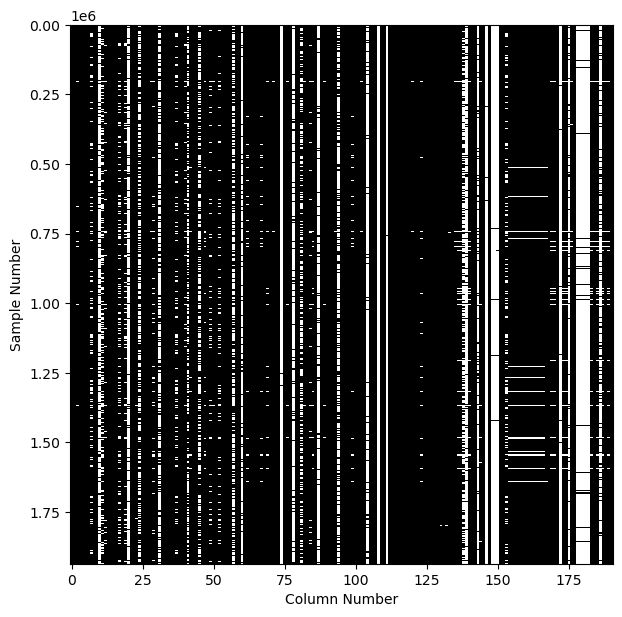

In [200]:
#Visually inspect Nans
plt.figure(figsize=(7, 7))
plt.imshow(eda_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.show()

As we can see, some columns seems to be have very high amounts of NaNs, lets find the columns to drop according to a 40% threshold below

In [201]:
del_cols = eda_df.isna().sum()/eda_df.shape[0]
print("Length before filtering out high Nan count cols: ",del_cols.size)
del_cols = del_cols.reset_index() 
del_cols.columns = ["Features","Percent_nans"]
del_cols = del_cols[del_cols.Percent_nans > 0.4]
print("Number of columns to drop: ",del_cols.size)


Length before filtering out high Nan count cols:  191
Number of columns to drop:  62


In [202]:
del_cols.Features.values

array(['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66',
       'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88',
       'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39',
       'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138',
       'D_142'], dtype=object)

Per the above we will drop all columns which are more than 40% NaNs. At some point the mean imputing will be futile.

Cols to delete = ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66',
       'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88',
       'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39',
       'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138',
       'D_142']

Lets look at the correlation of variables. But with a subsample of the data given the size

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


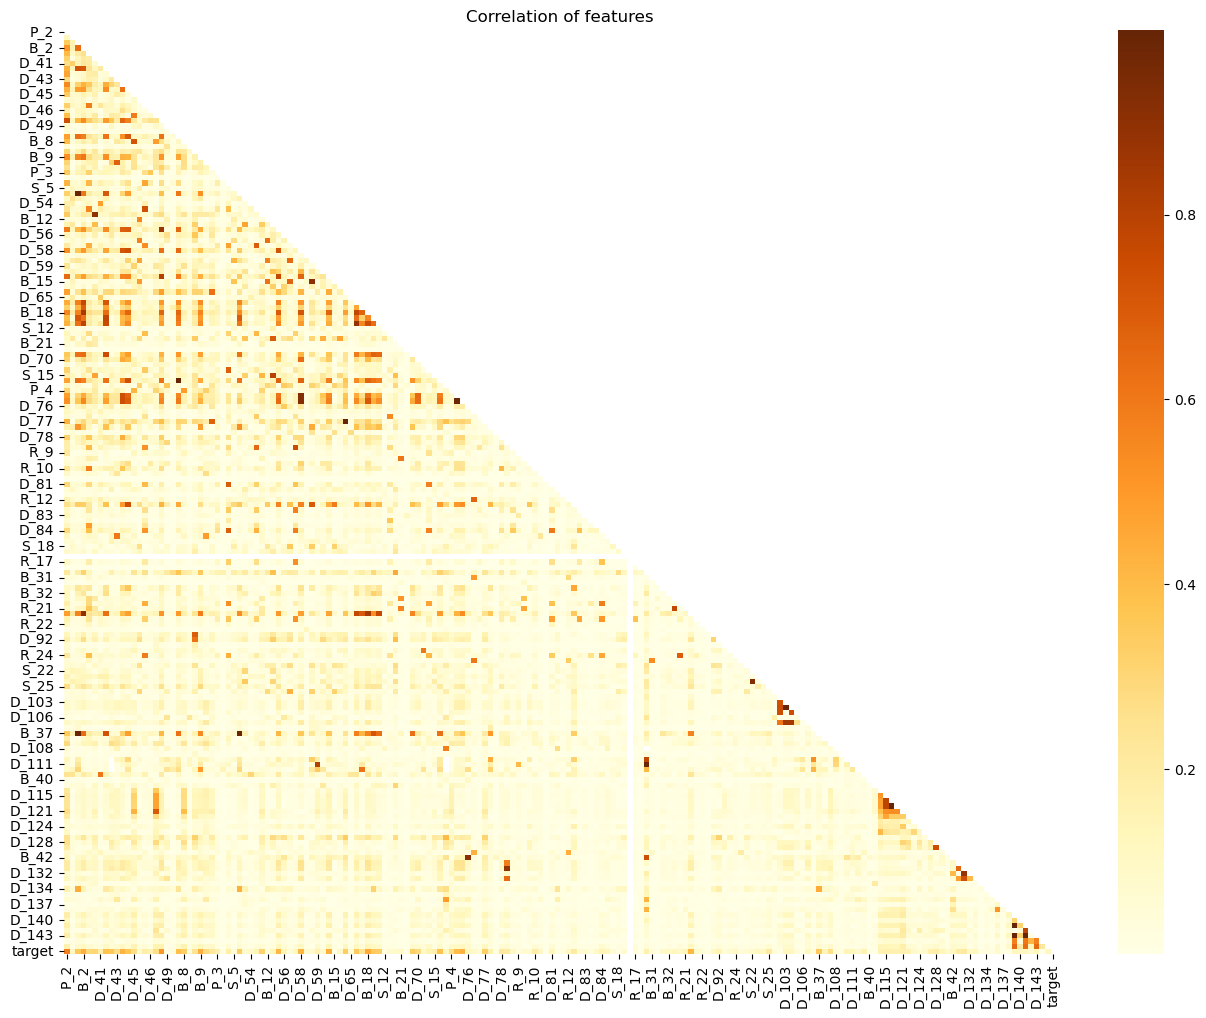

CPU times: user 27.2 s, sys: 961 ms, total: 28.2 s
Wall time: 27.9 s


In [203]:
%%time
sample_corr_df = eda_df.sample(frac=0.3, replace=False)
correlations = sample_corr_df.corr().abs()

mask=np.triu(np.ones_like(correlations))

fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of features")
plt.show()

In [204]:
#save some memory
del eda_df

___

## Pre-Processing & Feature Engineering

`Feature Engineeering`

In [6]:
#drop the ID column and date columns since it wont help out model
df.pop('customer_ID')
df.pop('S_2')

df.head(2)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
1514245,0.840332,0.385498,0.014931,0.255859,0.003902,0.148682,0.160400,0.040253,NaN,0.194092,...,NaN,NaN,0.007015,0.005955,0.000452,NaN,0.009331,0.007061,0.008537,0
1586367,0.608887,0.566895,0.037079,1.004883,0.001968,0.145142,0.006760,0.006065,NaN,0.242676,...,NaN,NaN,0.003370,0.004475,0.004517,NaN,0.007591,0.007519,0.007584,0


I need to drop the columns up from above which were predominantly NaNs
 ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']

In [7]:
del_cols = ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 
            'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108',
            'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']

for i in del_cols: 
    df.pop(i)

Lets check out the new dimensions of our data:

In [8]:
df.shape

(5531451, 158)

In [9]:
cols = df.columns
#new_cols = [i for i in cols if i not in del_cols]

B_38 needs to be reindex to start index 0

In [10]:
B_38_mapping = {label: idx for idx, label in enumerate(np.unique(df['B_38']))}
df['B_38'] = df['B_38'].map(B_38_mapping)

#lets confirm it worked
df['B_38'].value_counts()

1    1953232
2    1255315
0    1160047
4     444856
3     294917
6     259028
5     162040
Name: B_38, dtype: int64

Drop the categoricals with negative values, unclear what these signify

D_117
D_126
D_64

For D_63, this column need to be one hot encoded

In [11]:
df.pop('D_117')
df.pop('D_126')
df.pop('D_64')
display(df.columns.get_loc("D_63"))

45

In [12]:
col = df.columns

In [13]:
%%time
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [45])], remainder='passthrough')
df = columnTransformer.fit_transform(df)

CPU times: user 5.68 s, sys: 10.2 s, total: 15.9 s
Wall time: 23.7 s


In [14]:
#the onehot encoded cols need to be standardized as well
column_trans = ColumnTransformer([('scaler', StandardScaler(),[0,1,2,3,4,5])],
                                   remainder='passthrough') 
df = column_trans.fit_transform(df)

for all cols which we didnt drop due to our nan thresholds we will impute the mean

In [15]:
%%time 

imp=SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value = -1)
df=pd.DataFrame(imp.fit_transform(df))

CPU times: user 8.07 s, sys: 11.8 s, total: 19.8 s
Wall time: 22.9 s


In [16]:
#lets confirm it worked
np.array(df.isna().sum()/df.shape[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [17]:
col = list(col)
col.remove('D_63')

In [18]:
one_hot_cols = ['onehot1','onehot2','onehot3','onehot4','onehot5','onehot6']
new_cols = one_hot_cols + col

In [19]:
df.columns = new_cols

___

## Split the Datasets

`Lets Split the dataset`

In [178]:
X = df
Y = X.pop('target')

In [179]:
#shuffle default is True, we set to false to preserve time series ordering
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

# 0.25 x 0.8 = 0.2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,  shuffle = False) 

In [180]:
print('Training Features dimensions: ', X_train.shape)
print('Training Labels dimensions: ', Y_train.shape)
print('Validation Features dimensions: ', X_val.shape)
print('Validation Labels dimensions: ', Y_val.shape)
print('Test Features dimensions: ', X_test.shape)
print('Test Labels dimensions: ', Y_test.shape,'\n')

print('Training Percent of Positive Labels:  %.4f'%(Y_train.value_counts()[1]/Y_train.value_counts().sum()), '\n')
print('Validation Percent of Positive Labels:  %.4f'%(Y_val.value_counts()[1]/Y_val.value_counts().sum()))

Training Features dimensions:  (3318870, 190)
Training Labels dimensions:  (3318870,)
Validation Features dimensions:  (1106290, 190)
Validation Labels dimensions:  (1106290,)
Test Features dimensions:  (1106291, 190)
Test Labels dimensions:  (1106291,) 

Training Percent of Positive Labels:  0.2440 

Validation Percent of Positive Labels:  0.2553


Even though we did not ensure stratification of our label across training and test dataset, we have results in a pretty even distribution of labels

The last step, to save some memory lets delete the original datasets

In [181]:
del df, X, Y

___

## Dimensionality Reduction

Although the we would not necassarily require dimensionality reduction for our random forest model, given the size of our data (>5m rows) we will reduce the feature size in order to improve the efficiency of our training models. 

**first we need to figure out how many components to reduce down to**


In [ ]:
#did not output for easier printing
cov_matrix = np.cov(X_train.T)
pd.DataFrame(cov_matrix).head(30)

In [133]:
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

We are interested in the top  𝑘
  eigenvectors as defined by their coresponding eigenvalue. Let's plot the **explained variance ratio** of the eigenvalues:

$ = \frac{\lambda_j}{\sum_{j=1}^d \lambda_j}$, 
So the explained variance ratio is the fraction of an eigenvalue $j$ and the total sum of eigenvalues.

In [ ]:
# compute the explained variance ratio
sum_eigen_values = sum(eigen_values)
print('Sum eigenvalues: ', sum_eigen_values)

#did not output for easier printing
expl_var_ratio = [i/sum_eigen_values for i in sorted(eigen_values, reverse=True)]
print('\nExplained variance ratio:')
#did head method for easier printing
pd.DataFrame(expl_var_ratio).head(30)

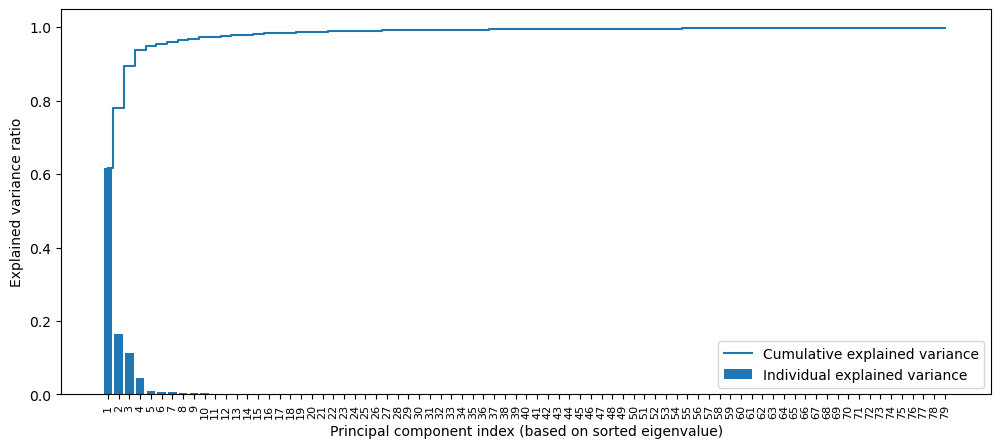

In [147]:
# visualize the explained variance ratio and the cumulative explained variance ratio
x_axis = range(1,(len(eigen_values)+1)//2)
y_axis = expl_var_ratio[:len(expl_var_ratio)//2]

# plot individual ratio
plt.figure(figsize=(12,5))
plt.bar(x_axis, y_axis, label='Individual explained variance')
# plot cumulative ratio
plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

# legend, labels, size
plt.legend()

plt.xticks(x_axis,rotation=90,fontsize=8)
plt.ylabel('Explained variance ratio');
plt.xlabel('Principal component index (based on sorted eigenvalue)');

From the above we can see that with just 10 principal components we are aleady able to explain approximately 90% of the variance in our dataset. We could specify our PCA to cover at least 95% of the explained variance however, this might result in our train, val, and test datasets having different number of features. 

We will implement the PCA adjustment in SKlearn pca class. The idea is to:
 - fit the data using the original X_train data
 - transform both X_train and X_test data using the same PCA parameters

In [113]:
#pca = PCA(n_components = 0.95)
pca = PCA(n_components = 15)

#transform the train, val and test
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_val)
X_test_pca = pca.fit_transform(X_test)

`PCA NOT USED DURING MODEL TRAINING AND PREDICTION`

After training the model on the new PCA adjusted features, the validation accuracy dropped by >20%. As such for the final model and prediction on the test dataset, the non-dimensionality dataset was utilized.

___

# Model Building

`Establish a baseline - always predict no default`

In order to help judge the usefulness and generalization of our Random Forest model, we should establish a baseline. 
For the credit default scenario, our baseline will be to predict the most frequently recurring event of either no default or default. As such the baseline accuracy rate we hope our model will beat is the 1-error rate, where error rate is the baseline error we would get if we simply predicted no default for all.

In [24]:
#calculating the baselines accuracy rate to beat 
rate = 1-(Y_train.value_counts()[1]/Y_train.value_counts().sum())
print('Baseline Accuracy Rate: %.4f' %rate)

Baseline Accuracy Rate: 0.7560


___

`Singular Decision Tree`

To begin, we will train a basic non parametric model using a singular decision tree. Then we will try to improve on this tree using the boosting algorithm. This ensemble classifier will provide a good idea of how useful our random forest will be. 

The initial formulation of the boosting algorithm (4 key steps):<br>
 1. Draw a random sample of training examples, 𝑑𝑑1, without
replacement from the training dataset, D, to train a weak learner, 𝐶𝐶1.
 2. Draw a second random sample of training examples, 𝑑𝑑2, without replacement from the
training dataset and add 50 percent of the examples that were previously
misclassified to train a weak learner, 𝐶𝐶2.
 3. Find the training examples, 𝑑𝑑3, in the training dataset, D, which 𝐶𝐶1 and 𝐶𝐶2
disagree upon, to train a third weak learner, 𝐶𝐶3.
 4. Combine the weak learners 𝐶𝐶1, 𝐶𝐶2, and 𝐶𝐶3 via majority voting.

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

See documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    

In [91]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=10)

In [150]:
ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=50)

Training and evaluating on the test datasets:

In [166]:
%%time
tree = tree.fit(X_train, Y_train)
y_train_pred = tree.predict(X_train)
y_val_pred = tree.predict(X_val)

tree_train = accuracy_score(Y_train, y_train_pred)
tree_val = accuracy_score(Y_val, y_val_pred)
print('Decision tree train/val accuracies %.3f/%.3f'% (tree_train, tree_val))

Decision tree train/val accuracies 0.856/0.863
CPU times: user 5min 50s, sys: 6.05 s, total: 5min 56s
Wall time: 5min 58s


In [ ]:
%%time
ada = ada.fit(X_train, Y_train)
y_train_pred = ada.predict(X_train)
y_val_pred = ada.predict(X_val)

ada_train = accuracy_score(Y_train, y_train_pred) 
ada_test = accuracy_score(Y_val, y_val_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'% (ada_train, ada_test))

**Note:** *Unable to run the above cell due to size of dataset*

___

`Building a random forest`

I will be implementing a **Random Forest model** which is an **ensemble** of decision tree classifiers. It is also a bagging method where deep trees (Decision Trees), fitted on bootstrap samples, are combined to produce an output with lower variance. (bootstrapping is random sampling with replacement from the available training data. Bagging is a bootstrap aggregation where we train an estimator for each bootstrapped dataset)

For each decision tree we start at the tree root (contains all data) and split the data on the feature that results in the largest Information Gain (IG).Unlike with a singular decision tree where we might consider pruning the length of our tree, a random forest help protect against overfitting. Why does the random forest model work so well: 

    A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models. (Wisdom of the Crowd)




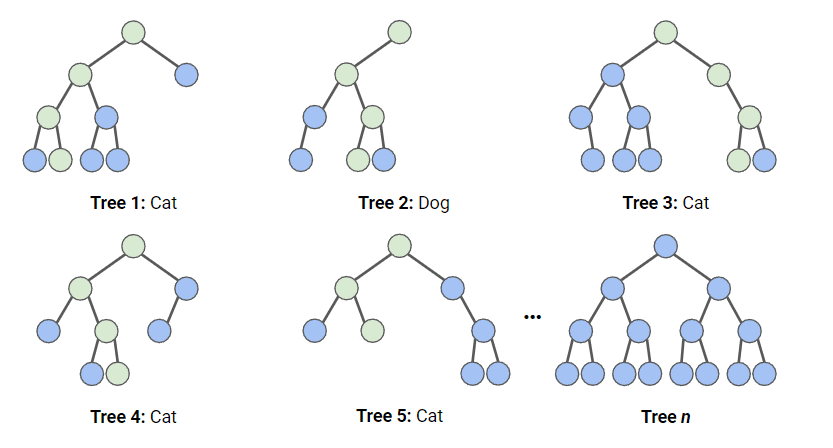

In [154]:
from IPython.display import Image
Image('/Users/julian/Documents/MIDS/W207/coursework_2022/final_project/amex-default-prediction/Randomforest.png',
      width=800)

*Why does the random forest not overfit?*

Although the individual decision trees within the Random Forest are not pruned, the random forest does not overfit. This is because within Random Forests we can introduce two sources of randomness: 

1. Bagging: Where each tree is trained on boostrapped samples (with replacements) to make up a unique subset of the training data. 
2. Attribute sampling: When we define our random forest, we are able to utilize Sklearn's max_features. This means that instead of considering all possible features when potentially splitting a node, only a random subset of features are tested at each node.

As such these two characteristics of our random forest ensure the relative independence between the decision trees. This independence corrects the overfitting of the individual decision trees. Consequently, the ensemble is not overfitted.


`Building a random forest`

In [27]:
%%time
random_forest = RandomForestClassifier(criterion='entropy', #function to measure the quality of a feature split
                                n_estimators=10, #number of trees in the forest 
                                bootstrap = True, #different sample for each estimator
                                max_samples = 0.6, #max number of samples is 50% of training data
                                n_jobs=2) # The number of jobs to run in parallel.
clf = random_forest.fit(X_train, Y_train)

CPU times: user 5min 46s, sys: 1.58 s, total: 5min 47s
Wall time: 2min 55s


In [28]:
#lets set up some predictions based on our test dataset:
y_train_pred_tree = clf.predict(X_train)
y_val_pred_tree = clf.predict(X_val)

Accuracy on Training Data: 0.9724
Accuracy on Validation Data: 0.8727
Validation Precision score: 0.8360
Validation Recall score: 0.8239
Validation F1 score 0.8296


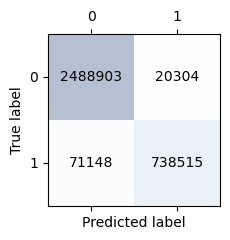

In [29]:
#lets look at the accuracy of our tree
print('Accuracy on Training Data: %.4f' %accuracy_score(Y_train,y_train_pred_tree))
print('Accuracy on Validation Data: %.4f' %accuracy_score(Y_val,y_val_pred_tree))
print('Validation Precision score: %.4f' % precision_score(Y_val,y_val_pred_tree, average='macro'))
print('Validation Recall score: %.4f' % recall_score(Y_val,y_val_pred_tree, average='macro'))
print('Validation F1 score %.4f' % f1_score(Y_val,y_val_pred_tree, average='macro'))

conf_matrix = confusion_matrix(Y_train,y_train_pred_tree) # confusion_matrix is available in sklearn.metrics
confusion_matrix_plot(conf_matrix)

In [124]:
# Get numerical feature importances
importances = list(random_forest.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

impfeatures = pd.DataFrame(feature_importances[:10], columns =['Feature', 'importance'])
impfeatures

,Feature,importance
0,P_2,0.062600
1,B_9,0.047840
2,B_7,0.041940
3,D_44,0.039490
4,B_2,0.033470
5,D_75,0.024320
6,B_6,0.022300
7,B_18,0.022140
8,D_45,0.020530
9,S_3,0.016830


Using the feature_importances attribute from SKlearn we can calculate the impurity-based feature importances. Above I am outputting the top 10 features

So far our data set looks to be performing quite well, with approx ~96% accuracy on our training data. While it is a good accuracy score, it was tested against the training data on which is was training so it is perhaps to be expected. As such there is some concern that overfitting has occured so we will try to attempt some hyperparameter tuning below. 

## Hyperparameter Tuning

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with **each combination of values**. Randomized search on hyper parameters, unlike the regular gridsearchCV

In [31]:
#first lets look at all the parameters which we have available to tune
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.6,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

From looking at the available parameters there are several which stand out: 
* max_features which is the max number of features considered at each tree split. Since we didnt specify this when intiating our RF classifier, the default is SQRT. Which is approx 12/13. So this is something we can try tune
* max_depth which is how many levels of branches we have in our model. Wasnt specified earlier so then nodes are expanded until all leaves are pure or until
* Max_samples number of samples to draw from X, to train the estimators
* min_samples_split - decides the minimum number of samples required to split an internal node. Default value =2. issue with 2 is that the condition is checked on the terminal node. If the data points in the node exceed the value 2, then further splitting takes place. Whereas if a more lenient value like 6 is set, then the splitting will stop early and the decision tree wont overfit on the data.
* min_samples_leaf - If after a split the data points in a node goes under the min_sample_leaf number, the split won’t go through and will be stopped at the parent node.

From the above we can see that there are many parameters which we can try and tune using cross validation as well. 

Note: The parameters selected are those that maximize the score of the held-out data, according to the scoring parameter.

Refer to the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

According to the documentation, the grid which we want to create is a dictionary type

In [32]:
criterion = ['entropy'] #what will be used to choose features at node splits
n_estimators = [i for i in range(10,18,2)] # number of trees in the random forest
bootstrap = [True] # drawing samples from our source data with replacement
max_samples = [i/10 for i in range(2,10,2)] #percentage of training samples to train each tree with
n_jobs=[-1]
max_features = ['sqrt']  #could add in 'log2' but took too long
max_depth = [i for i in range(110,160,10)] #max amount of layers in a tree
max_depth.append(None)  #if None, then nodes are expanded until all leaves are pure
min_samples_split = [2, 6, 10] # minimum sample number to split a node, need at least two to split
min_samples_leaf = [1,2, 3] # A split point at any depth will only be considered if it leaves at least 
                             #min_samples_leaf training samples in each of the left and right branches.
                              #This may have the effect of smoothing the model, especially in regression

random_grid = { 'criterion' : criterion, 
               'n_estimators' : n_estimators, 
               'bootstrap' : bootstrap,
               'max_samples' : max_samples,
               'n_jobs' : n_jobs,
               'max_features' : max_features, 
               'max_depth' : max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf' : min_samples_leaf
              }

In [33]:
%%time
#first we need to initiate a new base tree estimator 
base_tree =  RandomForestClassifier()

#initialize the random search CV hyperparameter tuner
Random_Forest_HyperTuned = RandomizedSearchCV(estimator = base_tree,
                                              param_distributions = random_grid,#params defines above
                                              n_iter = 8, #Number of parameter settings that are sampled from distribution define above
                                              cv = 3, #default is5-fold cross validation, so we will have 30 trees
                                              verbose = 1, #the higher, the more messages
                                              return_train_score = True # attribute will include training scores
                                             )
#now we need to train the model using our training data and labels
Random_Forest_HyperTuned.fit(X_train,Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 21min 23s, sys: 2min 17s, total: 23min 40s
Wall time: 12h 50min 54s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=8,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['entropy'],
                                        'max_depth': [110, 120, 130, 140, 150,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'max_samples': [0.2, 0.4, 0.6, 0.8],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [10, 12, 14, 16],
                                        'n_jobs': [-1]},
                   return_train_score=True, verbose=1)

*Note: in the above model we set n_iter to 8 and our cross validation to 3. This means that we will have 8 randomly sampling parameter settings (from our predefined distributions) resulting in 8 unique trees. Each of these trees will be trained/fitted on 3 different sets of bootstrapped training datasets. Resulting in 24 esitmators*

Now that we have ran the hyperparameter tuning, we can pull out the best supposed parameters used. 



In [109]:
Random_Forest_HyperTuned.best_params_

{'n_jobs': -1,
 'n_estimators': 16,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_samples': 0.8,
 'max_features': 'sqrt',
 'max_depth': 150,
 'criterion': 'entropy',
 'bootstrap': True}

Lets look at the feature importances on the final/best estimator:

In [ ]:
best_RF = Random_Forest_HyperTuned.best_estimator_

In [162]:
# Get numerical feature importances
importances = list(best_RF.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

impfeatures = pd.DataFrame(feature_importances[:10], columns =['Feature', 'importance'])
impfeatures

,Feature,importance
0,P_2,0.076980
1,D_44,0.038740
2,D_48,0.032910
3,D_45,0.029680
4,D_61,0.027010
5,B_20,0.025950
6,B_3,0.021830
7,B_2,0.020580
8,B_10,0.019860
9,B_18,0.018480


In [35]:
#generate predictions
y_pred_train = best_RF.predict(X_train)
y_pred_val = best_RF.predict(X_val)

Accuracy on Training Data: 0.9836
Accuracy on Validation Data: 0.8817
Validation Precision score: 0.8415
Validation Recall score: 0.8532
Validation F1 score 0.8471


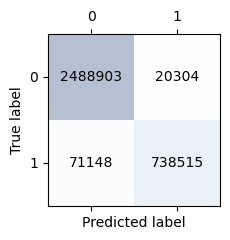

In [36]:
#lets look at the accuracy of our tree
print('Accuracy on Training Data: %.4f' %accuracy_score(Y_train,y_pred_train))
print('Accuracy on Validation Data: %.4f' %accuracy_score(Y_val,y_pred_val))
print('Validation Precision score: %.4f' % precision_score(Y_val,y_pred_val, average='macro'))
print('Validation Recall score: %.4f' % recall_score(Y_val,y_pred_val, average='macro'))
print('Validation F1 score %.4f' % f1_score(Y_val,y_pred_val, average='macro'))

confusion_matrix(Y_train,y_train_pred_tree) # confusion_matrix is available in sklearn.metrics
confusion_matrix_plot(conf_matrix)

Above we used the RandomizedSearchCV which in contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. 

Thus we can say the randomsearch gave us insight on values we can focus in on. With the gridsearch we will actually test all combination of the parameter dictionary, Grid search is used after randomised search to narrow down the range to search the perfect hyperparameters.

In [107]:
#given more computing power I would try more options below
random_grid_RandSearch = {'n_jobs': [-1],
               'n_estimators': [14,15,16],
               'min_samples_split': [2,3,4,5],
               'min_samples_leaf': [2,3,4,5],
               'max_samples': [0.4,0.5,0.6],
               'max_features': ['sqrt'],
               'max_depth': [125,130,135], #given more 
               'criterion': ['entropy'],
               'bootstrap': [True]}

In [ ]:
%%time
#first we need to initiate our final base tree estimator 
final_tree =  RandomForestClassifier()

#initialize our GridSearch object to finalize the hyperparameters
Final_Random_Forest = GridSearchCV(estimator = final_tree, 
                                   param_grid = random_grid_RandSearch,
                                   cv = 3, 
                                   n_jobs = -1, 
                                   verbose = 2
                                  )

#now we need to train the model using our training data and labels
Final_Random_Forest.fit(X_train,Y_train)

### Note: 
The above two cells (given my computing power) would not run. As such I will continue with the random forest hyperparameters according to the RandomizedSearchCV

### Save the model 

In [37]:
# save the model to disk, from pickle library
filename = 'finalized_model.sav'

In [38]:
pickle.dump(best_RF, open(filename, 'wb'))

### Reload the model

In [39]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## Performance Evaluation on Test Dataset

In [40]:
#generate predictions
y_pred_test = best_RF.predict(X_test)

Accuracy on Test Data: 0.8829
Test Precision score: 0.8422
Test Recall score: 0.8641
Test F1 score 0.8520


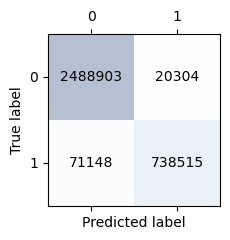

In [41]:
#lets look at the accuracy of our tree
print('Accuracy on Test Data: %.4f' %accuracy_score(Y_test,y_pred_test))
print('Test Precision score: %.4f' % precision_score(Y_test,y_pred_test, average='macro'))
print('Test Recall score: %.4f' % recall_score(Y_test,y_pred_test, average='macro'))
print('Test F1 score %.4f' % f1_score(Y_test,y_pred_test, average='macro'))

confusion_matrix(Y_train,y_train_pred_tree) # confusion_matrix is available in sklearn.metrics
confusion_matrix_plot(conf_matrix)

Visualize the result of our random forest vs intial base tree: 
* ROC curves should be used when there are roughly equal numbers of observations for each class.
* Precision-Recall curves should be used when there is a moderate to large class imbalance.

*Given our data classes are faily imbalanced lets visualize the Precision Recall Curve*. The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).



Text(0.5, 1.0, 'Precision-Recall Curve')

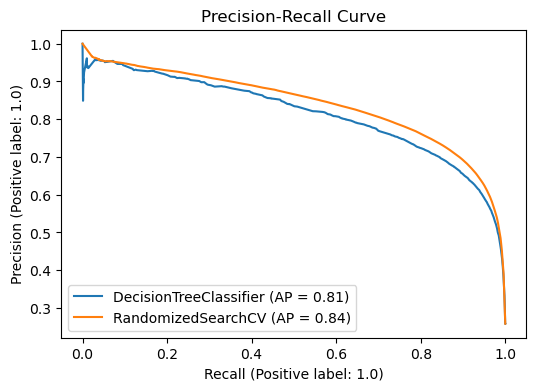

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
PrecisionRecallDisplay.from_estimator(tree, X_test, Y_test, drawstyle="default", ax = ax)
PrecisionRecallDisplay.from_estimator(Random_Forest_HyperTuned, X_test, Y_test,drawstyle="default", ax = ax)
plt.title('Precision-Recall Curve')


___

## Create the Kaggle Predictions and Submission File 

In [42]:
kaggle_test_features = pd.read_feather('test_data.ftr')
cust_IDS = kaggle_test_features['customer_ID']
kaggle_test_features.shape

(11363762, 190)

In [5]:
#define a function to preprocess kaggle test dataset
def data_preprocessing(df):
    df.pop('customer_ID')
    df.pop('S_2')

    del_cols = ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 
            'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108',
            'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']

    for i in del_cols: 
        df.pop(i)

    B_38_mapping = {label: idx for idx, label in enumerate(np.unique(df['B_38']))}
    df['B_38'] = df['B_38'].map(B_38_mapping)

    df.pop('D_117')
    df.pop('D_126')
    df.pop('D_64')

    columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [45])], remainder='passthrough')
    df = columnTransformer.fit_transform(df)

    imp=SimpleImputer(missing_values=np.NaN)
    df=pd.DataFrame(imp.fit_transform(df))

    return df

In [6]:
%%time
#run our test dataset through the preprocessing function
kaggle_test_features = data_preprocessing(kaggle_test_features)

CPU times: user 54.4 s, sys: 2min 5s, total: 3min
Wall time: 6min 45s


In [9]:
kaggle_test_features.head()

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.631348,0.001912,0.010727,0.814453,...,0.226801,0.123327,0.007080,0.005959,0.179609,0.004669,0.165575,0.179486,0.008278,0.063776
1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.586914,0.005276,0.011024,0.811035,...,0.007599,0.008072,0.007187,0.001253,0.000142,0.004940,0.009018,0.003695,0.003754,0.001460
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.608887,0.003326,0.016388,1.004883,...,0.003609,0.009865,0.008438,0.001924,0.000074,0.002113,0.004658,0.003155,0.002155,0.006481
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.614746,0.009064,0.021667,0.816406,...,0.006134,0.005898,0.002422,0.006756,0.004742,0.006393,0.002890,0.006042,0.005207,0.007858
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.591797,0.238770,0.015930,0.810547,...,0.006973,0.005310,0.000302,0.003578,0.008133,0.004330,0.008385,0.001008,0.007420,0.009468


### Reload the model

In [17]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

RandomForestClassifier(criterion='entropy', max_depth=150, max_samples=0.4,
                       min_samples_leaf=2, min_samples_split=6, n_estimators=16,
                       n_jobs=-1)

In [ ]:
#generate test dataset preds
kaggle_preds = loaded_model.predict(kaggle_test_features)

In [88]:
#ceate final submission df
sub_df = pd.DataFrame({'customer_ID': cust_IDS,
                       'prediction': kaggle_preds})
#turn the predictions into an integer, drop decimals places
sub_df['prediction'] = sub_df['prediction'].astype(int)

In [89]:
#aggregate by user id, get rid of duplicates
sub_df = sub_df.groupby(by='customer_ID').sum()

In [91]:
#change to binary output
sub_df['prediction'] = sub_df['prediction'].astype(bool).astype(int)

In [95]:
#turn the index into actual column
sub_df['customer_ID'] = sub_df.index

In [96]:
#transfer to submission csv file 
sub_df.to_csv('submission_file.csv',index=False)

___

## Key Takeaways & Considerations for next time:

* Consider other types of trees and ensemble methods. Sklearn has so many other  __[ensemble methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)__ which would be interesting to explore. Also gradient boosted trees would be interesting to look into.  
* In hindsight as random forests support natively numerical and categorical features perhaps I wouldnt have spent so much time on feature pre-processing.
* Random forests by default have very effective parameters, and hyperparameter tuning sometime has no value add. 
* Given the size of the data set, the number of decision trees in the model and the fact that cross validation was used, it was **incredibly slow** to train


In [169]:
#Export cleaned datasets to CSVs for other potential models
X_train.to_feather('amex_X_train.ftr')

In [170]:
X_val.to_csv('amex_X_val.ftr')

In [ ]:
X_test.to_csv('amex_X_test.ftr')

In [ ]:
Y_train.to_csv('amex_Y_train.ftr')

In [ ]:
Y_val.to_csv('amex_Y_val.ftr')

In [ ]:
X_test.to_csv('amex_Y_test.ftr')